In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import imageio_ffmpeg
print(imageio.__version__)
print(imageio_ffmpeg.__version__)
import imageio.v3 as iio
import glob

2.37.0
0.6.0


# Lecture 4: Review of the shallow water equations, pressure gradients, and inertia
Reading: Chapter 3.1

## Nonlinear steepening in the inviscid 1D Burger’s equation.
Approach: Use an upwind advection scheme to integrate the 1D inviscid Burgers' equation, starting from a Gaussian initial condition, and with periodic boundary conditions. 

### Burgers' Equation
1d advection-diffusion where diffusion = 0; unsteady advection

\begin{equation}
    \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0
\end{equation}

### Explicit (time) + Upwind Advection Scheme (space)
\begin{aligned}
    &\frac{u_i^{n+1} - u_i^n}{\Delta t} + \frac{u_i^n}{\Delta x} \left[u_i^n - u_{i-1}^n \right] = 0 \\
    \implies & u_i^{n+1} = (1-c)u_i^n + cu_{i-1}^n
\end{aligned}

where $c=\frac{u\Delta t}{\Delta x}$

### Gaussian initial condition
\begin{equation}
    u(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
\end{equation}

where $\sigma$ and $\sigma^2$ are the mean and standard deviation, respectfully. and $\mu$ is the mean.

In [2]:
# establish Gaussian initial condition
sigma = 1
variance = sigma**2
mu = 0
delta_x = 0.1
x_array = np.arange(-5,5,delta_x)
u_init = 1/(np.sqrt(2 * np.pi * variance)) * np.exp(- (x_array - mu)**2 / 2 * variance)

# establish CFL initial condition
delta_t = 0.1
c = u_init * delta_t / delta_x


def u(xi):
    gaussian = 1/(np.sqrt(2 * np.pi * variance)) * np.exp(- (xi - mu)**2 / 2 * variance)
    return gaussian

In [3]:
path = f'/pub/kailau/ESS280-gfd/Lecture04_ux_plots/'
filename = 'ux_045.png'

check_png_existence = os.path.isfile(path + filename)

if check_png_existence == True:
    print('U(x) file exists already')
else:
    u_array = np.expand_dims(u_init,0)
    CFL_violations = 0
    
    # n = rows, i = columns... [time, space]
    
    for n in range(0,500): # time (1 row = 1 timestep)
        u_i_np1_array = np.array([])
        curve_np1_array = np.array([])
        for i in range(0,len(x_array)): # space (1 column = 1 x-space distance)
            # u_i_end = u_array[n-1,-1] PERIODIC BOUNDARY CONDITIONS??
            # u_i_begin = u_i_end
            c = u_array[n,i] * delta_t / delta_x
            if u_array[n,i] * delta_t / delta_x >= 1:
                CFL_violations +=1
            u_i_np1 = (1-c)* u_array[n,i] + c * u_array[n,i-1]
    
            u_i_np1_array = np.append(u_i_np1_array, u_i_np1)
    
        u_array = np.vstack([u_array, u_i_np1_array])
    
        # make plot
        fig, ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(8,5))
        ax.plot(x_array,u_array[n])
        ax.set_xlim(-5,5)
        ax.set_ylim(-0.01,0.45)
        ax.set_xlabel('x')
        ax.set_ylabel('u(x)')
        ax.set_title(f'u(x) at t={n/10}')
    
        plt.savefig(f'/pub/kailau/ESS280-gfd/Lecture04_ux_plots/ux_{n:03d}.png',bbox_inches='tight')
        plt.close(fig)

U(x) file exists already


In [4]:
path = f'/pub/kailau/ESS280-gfd/'
filename = 'ux.mp4'

check_mp4_existence = os.path.isfile(path + filename)

if check_mp4_existence == True:
    print('u(x) movie already exists')
else:
    frames = sorted(glob.glob("/pub/kailau/ESS280-gfd/Lecture04_ux_plots/ux_*.png"))
    
    # Write MP4 directly — no plugin argument needed
    iio.imwrite(
        "/pub/kailau/ESS280-gfd/ux.mp4",
        [iio.imread(f) for f in frames],
        fps=10,
        codec="libx264"
    )

u(x) movie already exists


In [5]:
u_array = np.expand_dims(u_init,0)
CFL_violations = 0

# n = rows, i = columns... [time, space]

for n in range(0,1000): # time (1 row = 1 timestep)
    u_i_np1_array = np.array([])
    curve_np1_array = np.array([])
    for i in range(0,len(x_array)): # space (1 column = 1 x-space distance)
        # u_i_end = u_array[n-1,-1] PERIODIC BOUNDARY CONDITIONS??
        # u_i_begin = u_i_end
        c = u_array[n,i] * delta_t / delta_x
        if u_array[n,i] * delta_t / delta_x >= 1:
            CFL_violations +=1
        u_i_np1 = (1-c)* u_array[n,i] + c * u_array[n,i-1]

        u_i_np1_array = np.append(u_i_np1_array, u_i_np1)

    u_array = np.vstack([u_array, u_i_np1_array])

Text(0.5, 1.0, 'u(x) at t=4.5')

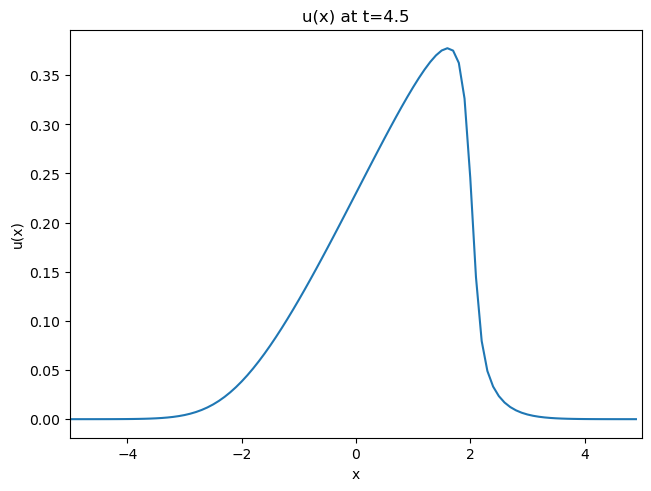

In [6]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.plot(x_array,u_array[45])
ax.set_xlim(-5,5)
ax.set_ylabel('u(x)')
ax.set_xlabel('x')
ax.set_title(f'u(x) at t=4.5')

# Why does this steepening occur? 
Consider the 1D inviscid Burgers' equation
\begin{aligned}
    \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0
\end{aligned}

Solutions to PDEs can be difficult to visualize, so we reduce the PDE to an ODE and look for **characteristic curves** that denote where there is a constant $u(x,t)$ solution in the x-t plane. 

The material derivative:
\begin{equation}
    \frac{du}{dt} = \underbrace{\frac{\partial u}{\partial t}}_{Eulerian \, (local)} + \underbrace{u\frac{\partial u}{\partial x}}_{Lagrangian \, (advective)}
\end{equation}

We can make the Lagrangian parcel velocity equal to the Eulerian local velocity. This ensures the velocity of the parcel along its pathway is constant. 
So if $\frac{dx}{dt} = u(x,t)$, and the velocity is constant so that the material derivative $\frac{du}{dt} = 0$, then we would find the characteristic curves, which represent parcel trajectories, have a constant $u$ velocity. 

For the characteristic curves such that the parameter $s=t=0$:

\begin{align}
    f(\xi) &= \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(\xi-\mu)^2}{2\sigma^2}} \, \, &(Gaussian \, initial \, condition, \, \xi \, is \, initial \, x-position) \\
    u(x,t=0) &= f(\xi)\\
    t &= s \\
    x &= tf(\xi) + \xi \,\, &(curve \, along \, which \, u(x,t) \, is \, constant)
\end{align}

Since $\xi$ is the value of $x$ at time $t=0$, we can rewrite the above equation for $x$ and substitute in $x$ for $\xi$ where $\xi$ is assumed to be constant.

\begin{align}
    x &= tf(\xi) + \xi \\
    x &= tu + \xi \\
    \xi &= x-ut \\ 
    \implies u&= f(\xi) = f(x-ut)     
\end{align}

This is how we know we will get a wave (we will continue to recover back the initial condition over time along each characteristic curve). 

### Characteristic curves
When we look at the characteristic curves over time for this system, we find that curves to the right of the Gaussian bump of velocity in space (i.e., where velocity is increasing) begin to flatten (in the $x-t$ plane, $m = 1/u(x,t)$; steeper lines mean lower velocity, flatter lines mean higher velocity). As time progresses, the velocity at that location in the x-direction is increasing (characteristic curves flatten). However, this flattening is not happening at all locations of x. This means that, within the x-domain, velocity is increasing at different speeds (e.g. at $t=4.5$, the slopes of the line at $x=0$ is flatter than the slope of the line at $x=1$.

e.g. at t = 4.5, if $m(x,t)=1/u(x,t)$ is the slope of the characteristic curve in the x-t plane (x on the x-axis, t on the y-axis):
\begin{align}
    m(0,4.5) &< m(1,4.5) \\
    \implies u(0,4.5) &> u(1,4.5) \\
\end{align}

Eventually, this acceleration causes the faster velocity regions to catch up to the slower velocity regions. This means there would then be multiple $u(x)$ solutions for a single $(x,t)$ point, creating a shock wave. The solution becomes discontinuous.

**for more information on method of characteristics, refer to Lecture 4 notes in the Google Drive.**

In [7]:
# plot characteristic curves
path = f'/pub/kailau/ESS280-gfd/Lecture04_char_plots/'
filename = 'char_045.png'

check_png_existence = os.path.isfile(path + filename)

if check_png_existence == True: 
    print('Characteristic curve file exists already')
else:
    fig_name_index = 0
    for t in np.arange(0,100,0.1):
        fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
        for xi in np.arange(-4,4,0.5):
            ptA_t = 0
            ptA_x = xi
            
            # find a second point to plot to get a line segment
            # in this case, make x = 5
            ptB_t = t + 0.1
            ptB_x = (ptB_t) * u(xi) + xi
            
            # stack the x values
            tt = np.vstack([ptA_t, ptB_t])
            xx = np.vstack([ptA_x, ptB_x])
            
        
            # make a plot 
            ax.plot(xx,tt,c='k')
            ax.set_xlim(-5,5)
            ax.set_ylabel('t')
            ax.set_xlabel('x')
            ax.set_title(f'Characteristic t(x) curves \n t={np.round(t,decimals=1)}')
    
        plt.savefig(f'/pub/kailau/ESS280-gfd/Lecture04_char_plots/char_{fig_name_index:03d}.png')
        plt.close(fig)
        fig_name_index +=1


Characteristic curve file exists already


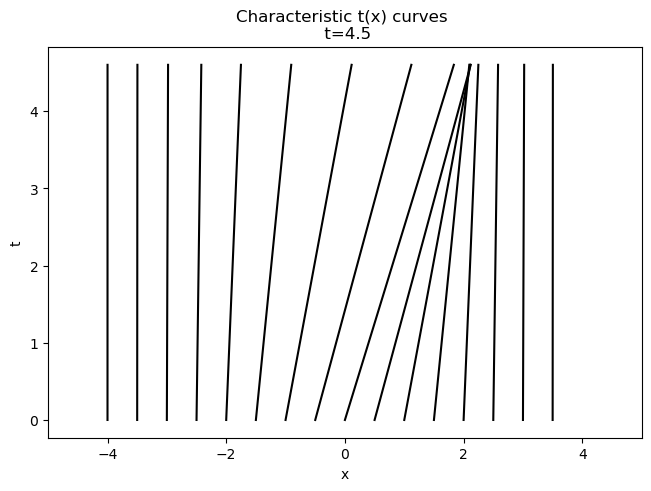

In [8]:
t = 4.5
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
for xi in np.arange(-4,4,0.5):
    ptA_t = 0
    ptA_x = xi
    
    # find a second point to plot to get a line segment
    # in this case, make x = 5
    ptB_t = t + 0.1
    ptB_x = (ptB_t) * u(xi) + xi
    
    # stack the x values
    tt = np.vstack([ptA_t, ptB_t])
    xx = np.vstack([ptA_x, ptB_x])
    

    # make a plot 
    ax.plot(xx,tt,c='k')
    ax.set_xlim(-5,5)
    ax.set_ylabel('t')
    ax.set_xlabel('x')
    ax.set_title(f'Characteristic t(x) curves \n t={np.round(t,decimals=1)}')

In [9]:
path = f'/pub/kailau/ESS280-gfd/'
filename = 'char.mp4'

check_mp4_existence = os.path.isfile(path + filename)

if check_mp4_existence ==True:
    print('char movie already exists')
else:
    frames = sorted(glob.glob("/pub/kailau/ESS280-gfd/Lecture04_char_plots/char_*.png"))
    
    # Write MP4 directly — no plugin argument needed
    iio.imwrite(
        "/pub/kailau/ESS280-gfd/char.mp4",
        [iio.imread(f) for f in frames],
        fps=10,
        codec="libx264"
    )

char movie already exists


# Bonus- Laplacian viscosity

How do we know if shock waves will form? Start from a system of equations for $u(x,t)$ s.t. we get the characteristic equations at t=0.
\begin{align}
    \begin{cases}
        u &= f(\xi) \\
        x &= tf(\xi) + \xi \implies \xi = x-tu
    \end{cases}
\end{align}

Begin by differentiating $u$ w.r.t. $x$
\begin{equation}
    \frac{\partial u}{\partial x} = \frac{\partial}{\partial x}\left[f(\xi(x))\right] = \frac{\partial f}{\partial \xi}\frac{\partial \xi}{\partial x} = f^\prime \frac{\partial \xi}{\partial x}
\end{equation}

Plug in $\xi = x-tu$ and solve for $\frac{\partial u}{\partial x}$.
\begin{align}
    \frac{\partial u}{\partial x} &= f^\prime \frac{\partial \xi}{\partial x} = f^\prime \frac{\partial}{\partial x} \left[x-tu\right] \\
    &= f^\prime \times \left(\frac{\partial x}{\partial x} - \frac{\partial}{\partial x}\left[tu\right]\right) \\
    \frac{\partial u}{\partial x} &= f^\prime \times \left(1 - t \frac{\partial u}{\partial x}\right) \\
    \frac{\partial u}{\partial x} &= f^\prime - f^\prime t \frac{\partial u}{\partial x} \\
    \frac{\partial u}{\partial x} + f^\prime t \frac{\partial u}{\partial x} &= f^\prime \\
    \frac{\partial u}{\partial x} \times \left(1+f^\prime t\right) &= f^\prime \\
    \frac{\partial u}{\partial x} &= \frac{f^\prime}{1+ f^\prime t} \\
    \frac{\partial u}{\partial x} &= \frac{f^\prime(\xi)}{1+tf^\prime (\xi)} \tag{1}
\end{align}

If we consider the characteristic curves in the x-t plane where each line represents a constant $u(x,t)$ velocity. We get a shock when the characteristic curves intersect. In other words, we get multiple velocities at a single $x$-value. For two characteristic lines with different $\xi$ values, the $x$-value is now the same. In other words, $x(\xi_0) - x(\xi_1) = \delta \xi = 0$, which implies $\frac{\partial x}{\partial \xi} = 0$. From here, we can relate shock wave formation to $\frac{\partial u}{\partial x}$.

Apply chain rule.
\begin{align}
    \frac{\partial u(x(\xi))}{\partial x} &= \frac{\partial u}{\partial \xi} \times \frac{\partial \xi}{\partial x} \\
    \frac{\partial u}{\partial x} &= \frac{\partial u}{\partial \xi} \times \frac{1}{\frac{\partial x}{\partial \xi}}
\end{align}

But if $\frac{\partial x}{\partial \xi} =0$, then the second term will go to $\infty$. 

In other words, we will get a shock when $\frac{\partial u}{\partial x} \rightarrow \infty$. Rewriting $\frac{\partial u}{\partial x}$ using Equation 1, we get that 
\begin{equation}
    \frac{\partial u}{\partial x} = \frac{f^\prime (\xi)}{1+tf^\prime(\xi)} \rightarrow \infty \tag{2}
\end{equation} 

This also now allows us to determine *when* the shock wave will occur.
\begin{align}
    1+tf^\prime(\xi) &\rightarrow 0 \\
    t &\rightarrow \frac{-1}{f^\prime(\xi)}
\end{align}

Returning to Equation 2, we know that if $\frac{\partial u}{\partial x} \rightarrow \infty$, then we will get a shock wave. 

**We will now demonstrate that the inclusion of the Laplacian viscosity, which smooths steep velocity gradients (when $\frac{\partial u}{\partial x}$ gets large), will prevent the formation of a shock wave.**

### The 1D unsteady advection-diffusion equation.

\begin{equation}
    \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}

### Explicit in time, upwind for advection, central-differencing for diffusion
\begin{equation}
\underbrace{\frac{u_i^{n+1} - u_i^n}{\Delta t}}_{\frac{\partial u}{\partial t}} + \underbrace{a\frac{u_i^{n}-u_{i-1}^{n}}{\Delta x}}_{a\frac{\partial u}{\partial x}} = \underbrace{\nu \frac{u_{i-1}^n - 2u_i^n + u_{i+1}^n}{\Delta x^2}}_{\nu \frac{\partial ^2 u}{\partial x^2}}
\end{equation}

Rearrange the scheme to solve for $u_i^{n+1}$

\begin{equation}
u_i^{n+1} = \underbrace{\nu \Delta t \frac{u_{i-1}^n -2u_i^n + u_{i+1}^n}{\Delta x^2}}_{\nu \Delta t \frac{\partial ^2 u}{\partial x^2}} - \underbrace{a \Delta t \frac{u_i^n - u_{i-1}^n}{\Delta x}}_{a \Delta t \frac{\partial u}{\partial x}} + u_i^n
\end{equation}

Note that a shock will never form because the velocity gradient will never approach infinity. Also note that the method of characteristics cannot be used to further analyze this problem because of the inclusion of the second derivative. 

In [12]:
# establish a value for viscosity
nu = 1*10**(-2)

In [11]:
u_array = np.expand_dims(u_init,0)
for n in range(0,100):
    u_i_np1_array = np.array([])
    for i in range(0,len(x_array)-1):
        u_n = u_array[-1]
        c = u_array[n,i] * delta_t / delta_x
        u_i_np1 = (nu * delta_t * (u_n[i-1] - 2*u_n[i] + u_n[i+1]) / (delta_x**2)) - (c * delta_t * (u_n[i] - u_n[i-1]) / delta_x) + u_n[i]
        # u_i_begin = u_i_end PERIODIC BOUNDARY CONDITIONS??
        u_i_np1_array = np.append(u_i_np1_array, u_i_np1)

    u_i_end = u_array[n-1,-1]
    u_i_np1_array = np.append(u_i_np1_array, u_i_end)
    u_array = np.vstack([u_array, u_i_np1_array])
        

Text(0, 0.5, 'u(x)')

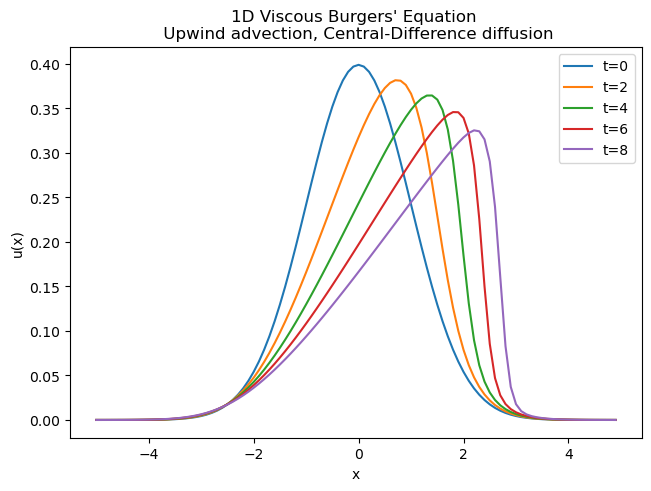

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
for i in range(0,5):
    ax.plot(x_array,u_array[i*20],label=f't={i*2}')
ax.legend()
ax.set_title('1D Viscous Burgers\' Equation \n Upwind advection, Central-Difference diffusion')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

# Bonus- Comparison with the central-differencing advection scheme

Now let's consider the numerical methods. 
>- diffusion refers to the smoothing of steep gradients. It can be non-physical (i.e., it will show up in a purely advective scheme, even if it is not prescribed)
>- dispersion refers to change in shape of a wave because its Fourier modes move at different speeds.
>- The first-order upwind scheme (used for advection thus far in the notebook) is diffusive but not dispersive.
>- The second-order central-differencing scheme is dispersive but not diffusive (preserves the material derivative $\frac{du}{dt} =0$. 

### Inviscid 1D Burgers' Equation 
1d advection-diffusion where diffusion = 0; unsteady advection

\begin{equation}
    \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0
\end{equation}

### Explicit (time) + Central-Differencing Advection Scheme (space)
\begin{equation}
\underbrace{\frac{u_i^{n+1} - u_i^n}{\Delta t}}_{\frac{\partial u}{\partial t}} + \underbrace{u \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x}}_{a\frac{\partial u}{\partial x}} = 0
\end{equation}

Solve for $u_i^{n+1}$

\begin{align}
    u_i^{n+1} &=  - \underbrace{u \Delta t \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x}}_{u \Delta t \frac{\partial u}{\partial x}} + u_i^n \\
    u_i^{n+1} &= - c (u_{i+1}^n - u_{i-1}^n) + u_i^n
\end{align}

where $c= u \frac{\Delta t}{2\Delta x}$

**For central differencing, because it is a dispersive scheme, the shock waves will propagate at different speeds. This is not the case for the upwind scheme, where the shock waves will propagate at teh same speed.**

In [8]:
u_array = np.expand_dims(u_init,0)
CFL_violations = 0
delta_t = 0.1
for n in range(0,100): # time
    u_i_np1_array = np.array([])
    for i in range(0,len(x_array)-1):
        u_n = u_array[-1]
        c = u_array[n,i] * delta_t / (2 * delta_x)
        if u_array[n,i] * delta_t / delta_x >= 1:
            CFL_violations +=1
        u_i_np1 = -c * (u_n[i+1] - u_n[i-1]) + u_n[i]
        u_i_np1_array = np.append(u_i_np1_array, u_i_np1)
        
    u_i_end = u_array[n-1,-1]
    u_i_np1_array = np.append(u_i_np1_array, u_i_end)
    u_array = np.vstack([u_array, u_i_np1_array])

In [9]:
CFL_violations

77

Text(0, 0.5, 'u(x)')

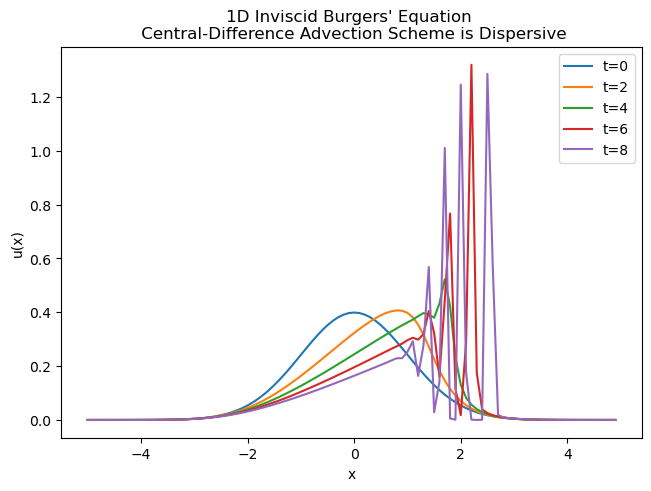

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
for i in range(0,5):
    ax.plot(x_array,u_array[i*20],label=f't={i*2}')
ax.legend()
ax.set_title('1D Inviscid Burgers\' Equation \n Central-Difference Advection Scheme is Dispersive')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

## Explicit in time, central-difference for advection, central-difference for diffusion
\begin{equation}
\underbrace{\frac{u_j^{n+1} - u_j^n}{\Delta t}}_{\frac{\partial u}{\partial t}} - \underbrace{a \frac{u_{j+1}^{n+1} - u_{j-1}^{n+1}}{2\Delta x}}_{a\frac{\partial u}{\partial x}} = \underbrace{\nu \frac{u_{j-1}^{n+1} - 2u_j^{n+1} + u_{j+1}^{n+1}}{\Delta x^2}}_{\nu \frac{\partial ^2 u}{\partial x^2}}
\end{equation}

solve for $u_j^n$ to build a coefficient matrix $A$.

\begin{equation}
u_j^n = \left(-\frac{\nu \Delta t}{\Delta x^2} - \frac{a \Delta t}{2\Delta x} \right)u_{j-1}^{n+1} + \left(- \frac{2 \nu \Delta t}{\Delta x^2} + 1 \right) u_j^{n+1} + \left(-\frac{\nu \Delta t}{\Delta x^2} + \frac{a\Delta t}{2\Delta x} \right) u_{j+1}^{n+1}
\end{equation}

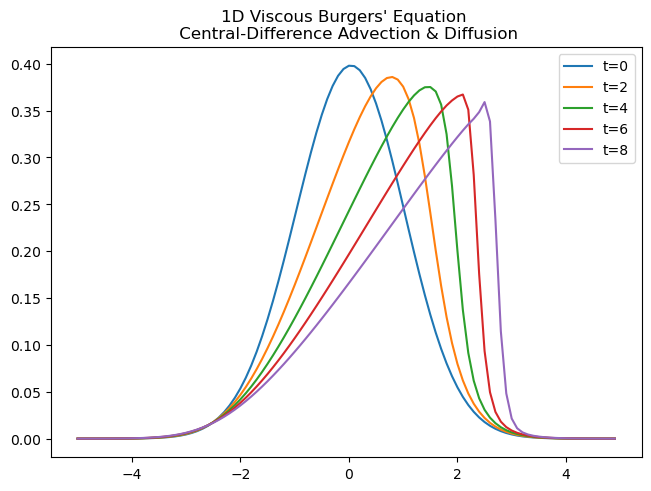

In [13]:
fig,ax= plt.subplots(nrows=1,ncols=1,constrained_layout=True)

max_steps = 100

# use initial condition to set initial b vector
b = u_init

for t in range(0,100):
    # make A matrix
    A = np.zeros((max_steps,max_steps)) # to prevent the matrix from being singular, create A matrix that is the size of maximum between time steps and space steps

    A[-1,-1] = 1
    A[0,0] = 1
    
    for i in range(1,max_steps-1):
        a = b[i]

        iminus1_coeff = (-nu * delta_t / delta_x**2) - (a * delta_t / (2 * delta_x))
        i_coeff = 2 * nu * delta_t / delta_x**2 + 1
        iplus1_coeff = -nu * delta_t / delta_x**2 + (a * delta_t / (2 * delta_x))
        
        A[i,i] = i_coeff
        A[i,i-1] = iminus1_coeff
        A[i,i+1] = iplus1_coeff
    
    x = np.linalg.solve(A,b)
    x[0] = 0
    x[-1] = 0 
    b = x
    if np.isin(t,np.arange(0,5)*20):
        ax.plot(x_array,x,label=f't={np.int32(t/10)}')

ax.set_title('1D Viscous Burgers\' Equation \n Central-Difference Advection & Diffusion')
ax.legend()